In [1]:
import numpy as np
import pandas as pd

In [2]:
np.seterr(divide='ignore', invalid='ignore');

In [3]:
data_types_dict = {
        "user_id":"int32",
        "content_id":"int16",
        "answered_correctly":"int8",
        "prior_question_elapsed_time":"float32",
        "prior_question_had_explanation":"bool"    
}
target = 'answered_correctly'

## Basic feature-engineering 

In [15]:
train_df = pd.read_csv(r'../data/train.csv', nrows=1e+6, usecols = set(data_types_dict.keys()))
train_df = train_df[train_df[target]!= -1].reset_index(drop=True)
train_df['prior_question_had_explanation'].fillna(False, inplace=True) ##replace nans with bool False
train_df = train_df.astype(data_types_dict)

In [16]:
train_df.head()

,user_id,content_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,115,5692,1,NaN,False
1,115,5716,1,37000.0,False
2,115,128,1,55000.0,False
3,115,7860,1,19000.0,False
4,115,7922,1,11000.0,False


In [17]:
train_df.shape

(980093, 5)

In [30]:
train_df['lag'] = train_df.groupby('user_id')[target].shift()
cum = train_df.groupby('user_id')['lag'].agg(['cumsum', 'cumcount']) ##cumsum -> total correct | cumcount -> all attempted
train_df['user_correctness'] = cum['cumsum']/cum['cumcount'] ##average correctness of every user
train_df.drop(columns=['lag'], inplace=True)

In [31]:
cum

,cumsum,cumcount
0,NaN,0
1,1.0,1
2,2.0,2
3,3.0,3
4,4.0,4
...,...,...
980088,13.0,43
980089,14.0,44
980090,15.0,45
980091,15.0,46


<AxesSubplot:ylabel='Frequency'>

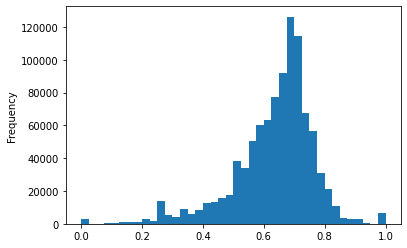

In [34]:
train_df['user_correctness'].plot.hist(bins=40)

In [37]:
user_agg = train_df.groupby('user_id')[target].agg(['sum', 'count'])
content_agg = train_df.groupby('content_id')[target].agg(['sum', 'count'])

In [41]:
train_df = train_df.groupby('user_id').tail(24).reset_index(drop=True)

In [44]:
questions_df = pd.read_csv('../data/questions.csv', usecols = [0,3], 
                           dtype={'question_id':'int16', 'part':'int8'})

train_df = pd.merge(train_df, questions_df, left_on='content_id', right_on='question_id', how='left')
train_df.drop(columns=['question_id'], inplace=True)

In [45]:
train_df

,user_id,content_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,user_correctness,part
0,115,45,0,19000.0,False,0.727273,1
1,115,185,0,21000.0,False,0.695652,1
2,115,55,1,22000.0,False,0.666667,1
3,115,7876,1,16000.0,False,0.680000,1
4,115,6,1,20000.0,False,0.692308,1
...,...,...,...,...,...,...,...
86378,20949024,8803,1,14000.0,True,0.302326,5
86379,20949024,4664,1,17000.0,True,0.318182,5
86380,20949024,4108,0,18000.0,True,0.333333,5
86381,20949024,5014,0,6000.0,True,0.326087,5


In [49]:
train_df['content_count'] = train_df['content_id'].map(content_agg['count']).astype('int32')
train_df['content_id'] = train_df['content_id'].map(content_agg['sum'] / content_agg['count']) ##content_id is not raelly content_id anymore

In [50]:
valid_df = train_df.groupby('user_id').tail(6) ##take 1/4 of every user as valid dataframe
train_df.drop(valid_df.index, inplace=True)

In [51]:
valid_df.shape

(22923, 8)

In [52]:
train_df.shape

(63460, 8)

In [54]:
train_df

,user_id,content_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,user_correctness,part,content_count
0,115,0.684971,0,19000.0,False,0.727273,1,346
1,115,0.634703,0,21000.0,False,0.695652,1,438
2,115,0.585938,1,22000.0,False,0.666667,1,384
3,115,0.417434,1,16000.0,False,0.680000,1,1847
4,115,0.459459,1,20000.0,False,0.692308,1,518
...,...,...,...,...,...,...,...,...
86372,20949024,0.877462,1,19000.0,True,0.297297,2,1371
86373,20949024,0.742424,1,16000.0,True,0.315789,2,132
86374,20949024,0.816794,0,16000.0,True,0.333333,2,131
86375,20949024,0.840909,0,20000.0,True,0.325000,5,132


## Training

In [62]:
features = ['content_id',
            'prior_question_elapsed_time',
            'prior_question_had_explanation',
            'user_correctness',
            'part',
            'content_count']

### 1. LightGBM

In [99]:
import lightgbm as lgb

In [63]:
%%time

params = {'objective':'binary',
          'seed':42,
          'metric':'auc',
          'learning_rate':0.05,
          'max_bin':800,
          'num_leaves':80
         }
tr_data = lgb.Dataset(train_df[features], label = train_df[target])
va_data = lgb.Dataset(valid_df[features], label = valid_df[target])

model = lgb.train(params, 
                  tr_data, 
                  num_boost_round=10000, 
                  valid_sets=[tr_data, va_data], 
                  early_stopping_rounds = 100, 
                  verbose_eval=50)


[LightGBM] [Info] Number of positive: 34969, number of negative: 28491
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001029 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2706
[LightGBM] [Info] Number of data points in the train set: 63460, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.551040 -> initscore=0.204874
[LightGBM] [Info] Start training from score 0.204874
Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.774488	valid_1's auc: 0.733889
[100]	training's auc: 0.787538	valid_1's auc: 0.733756
[150]	training's auc: 0.797558	valid_1's auc: 0.732775
Early stopping, best iteration is:
[69]	training's auc: 0.779495	valid_1's auc: 0.734152
Wall time: 2.7 s


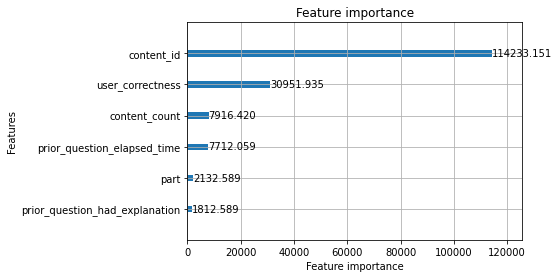

In [64]:
# model.save_model(f'model.txt')
lgb.plot_importance(model, importance_type='gain')
plt.show()

In [71]:
valid_predictions = model.predict(valid_df[features])

In [96]:
from sklearn.metrics import roc_auc_score
roc_auc_score(valid_df[target].values, valid_predictions)

0.7341519081778682

### 2. Xgboost

In [90]:
import xgboost as xgb

x_train_data = xgb.DMatrix(train_df[features], label = train_df[target])
x_val_data = xgb.DMatrix(valid_df[features], label = valid_df[target])


eta = 0.1
max_depth= 5
subsample = 1
colsample_bytree = 1

params = {
        "objective": "binary:logistic",
        "booster" : "gbtree",
        "eval_metric": "auc",
        "eta": eta,
        "tree_method": 'exact',
        "max_depth": max_depth,
        "subsample": subsample,
        "colsample_bytree": colsample_bytree,
        "seed": 42,
    }

num_rounds = 1000

mod = xgb.train(params=params,
                dtrain=x_train_data,
                num_boost_round=num_rounds,
                early_stopping_rounds=100,
                evals=[(x_train_data,'train'), (x_val_data,'valid')],
                verbose_eval=20)

# make prediction
#preds = mod.predict(dtest)

[0]	train-auc:0.75066	valid-auc:0.72307
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 100 rounds.
[20]	train-auc:0.76055	valid-auc:0.73175
[40]	train-auc:0.76436	valid-auc:0.73356
[60]	train-auc:0.76688	valid-auc:0.73420
[80]	train-auc:0.76921	valid-auc:0.73437
[100]	train-auc:0.77129	valid-auc:0.73449
[120]	train-auc:0.77351	valid-auc:0.73425
[140]	train-auc:0.77558	valid-auc:0.73404
[160]	train-auc:0.77757	valid-auc:0.73384
[180]	train-auc:0.77956	valid-auc:0.73354
Stopping. Best iteration:
[94]	train-auc:0.77079	valid-auc:0.73457



### 3. Catboost

In [97]:
from catboost import CatBoostClassifier

In [98]:
%%time

clf = CatBoostClassifier(
    iterations=500, 
    learning_rate=0.1, 
    eval_metric='AUC',
    early_stopping_rounds = 50, 
)


clf.fit(train_df[features], train_df[target], 
        eval_set=(valid_df[features], valid_df[target]), 
        verbose=50)


0:	test: 0.7062981	best: 0.7062981 (0)	total: 117ms	remaining: 58.6s
50:	test: 0.7345326	best: 0.7345326 (50)	total: 1.57s	remaining: 13.8s
100:	test: 0.7361308	best: 0.7361477 (99)	total: 3.03s	remaining: 12s
150:	test: 0.7362390	best: 0.7363584 (135)	total: 4.48s	remaining: 10.4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7363584468
bestIteration = 135

Shrink model to first 136 iterations.
Wall time: 7.63 s


### Conclusions

* Catboost out-of-the-box is better than xgboost which is (only) slightly better than lgbm. 

* XGboost is fastest but that's probably because it finds the minima faster

## To-do

* Use randomized or grid search to find optimal hyperparamters
* Use better CV (K-Folds/Grouped K-Fold) to reduce overfitting

